# Classifying newswires with tf.keras and tf.data using eager execution.

In [6]:
import tensorflow as tf
import numpy as np
import random

In [3]:
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.reuters.load_data(num_words=10000)

In [4]:
print(len(train_data))
print(len(test_data))

8982
2246


### Converting the integers to words

In [5]:
word_to_integer = tf.keras.datasets.reuters.get_word_index()

557056/550378 [==============================] - 0s 0us/step


In [7]:
print(list(word_to_integer.keys())[0:10])

integer_to_word = dict([(value, key) for (key, value) in word_to_integer.items()])

# Find the word from an integer
print(integer_to_word[1])
print(integer_to_word[2])

random_index = random.randint(0, 100)
# Subtract 3 from the indices (0 is "padding", 1 is "start of sequence", and 2 is "unknown")
decoded_newswire = ' '.join([integer_to_word.get(i - 3, 'UNK') for i in train_data[random_index]])
print(decoded_newswire)
print(train_labels[random_index])

['mdbl', 'fawc', 'degussa', 'woods', 'hanging', 'localized', 'sation', 'chanthaburi', 'refunding', 'hermann']
the
of
UNK australia's crude oil tax strategy is probably best UNK in terms of a targeted rather than broadly based approach federal resources and energy minister UNK evans told a meeting here he told the australian petroleum exploration association apea annual conference there was a prospect of developing a package that would recognise the government's economic priorities while also meeting some of the industry's concerns evans was referring to a nearly completed government review of oil taxation evans said there were plenty of UNK where targeted approaches to oil industry taxation had produced good results in recent years these include the reduction in the top marginal crude excise rate on UNK bass strait oil found before september 1975 to 80 pct from 87 pct and the waiver of excise on onshore oil announced last september he said the industry through the apea has been calling

### Format the data
Multi-hot encode the newswire dataset

In [8]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension), dtype=np.float32)
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results


train_data = vectorize_sequences(train_data)
test_data = vectorize_sequences(test_data)

print(train_data.shape)
print(train_data[0])

(8982, 10000)
[0. 1. 1. ... 0. 0. 0.]


### Format the labels

Use [tf.keras.utils.to_categorical](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) to one hot encode the labels.

In [11]:
LABEL_DIMENSIONS = 46

print(train_labels[0]) # Before
train_labels  = tf.keras.utils.to_categorical(train_labels, LABEL_DIMENSIONS)
print(train_labels[0]) # After

test_labels = tf.keras.utils.to_categorical(test_labels, LABEL_DIMENSIONS)

# Needed later
train_labels = train_labels.astype(np.float32)
test_labels = test_labels.astype(np.float32)

3
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### Construct a model

Simple sequential layers

In [12]:
### Create a model
model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu, input_shape=(10000,)))
model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(LABEL_DIMENSIONS, activation=tf.nn.softmax))

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640064    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 46)                2990      
Total params: 647,214
Trainable params: 647,214
Non-trainable params: 0
_________________________________________________________________


### Validation set

In [15]:
VAL_SIZE = 1000

val_data = train_data[:VAL_SIZE]
partial_train_data = train_data[VAL_SIZE:]


val_labels = train_labels[:VAL_SIZE]
partial_train_labels = train_labels[VAL_SIZE:]

### Create a tf.data Dataset

In [16]:
BATCH_SIZE = 512
TRAINING_SIZE = partial_train_labels.shape[0]

training_set = tf.data.Dataset.from_tensor_slices((partial_train_data, partial_train_labels))
training_set = training_set.shuffle(TRAINING_SIZE).batch(BATCH_SIZE)

### Training the model

In [17]:
EPOCHS = 10

# Store list of metric values for plotting
tr_loss_list = []
tr_accuracy_list = []
val_loss_list = []
val_accuracy_list = []

for epoch in range(EPOCHS):
    for newswires, labels in training_set:
        # Calculate training loss and accuracy
        tr_loss, tr_accuracy = model.train_on_batch(newswires, labels)
  
    # Calculate validation loss and accuracy
    val_loss, val_accuracy = model.evaluate(val_data, val_labels)

    # Add to the lists
    tr_loss_list.append(tr_loss)
    tr_accuracy_list.append(tr_accuracy)
    val_loss_list.append(val_loss)
    val_accuracy_list.append(val_accuracy)
  
    print(('Epoch #%d\t Training Loss: %.2f\tTraining Accuracy: %.2f\t'
           'Validation Loss: %.2f\tValidation Accuracy: %.2f') % (epoch + 1, 
                                                                  tr_loss, 
                                                                  tr_accuracy,
                                                                  val_loss, 
                                                                  val_accuracy))

1000/1000 [==============================] - 0s 131us/sample - loss: 1.8130 - accuracy: 0.6430
Epoch #1	 Training Loss: 1.96	Training Accuracy: 0.65	Validation Loss: 1.81	Validation Accuracy: 0.64
1000/1000 [==============================] - 0s 63us/sample - loss: 1.3095 - accuracy: 0.7260
Epoch #2	 Training Loss: 1.33	Training Accuracy: 0.73	Validation Loss: 1.31	Validation Accuracy: 0.73
1000/1000 [==============================] - 0s 62us/sample - loss: 1.1327 - accuracy: 0.7600
Epoch #3	 Training Loss: 1.03	Training Accuracy: 0.78	Validation Loss: 1.13	Validation Accuracy: 0.76
1000/1000 [==============================] - 0s 63us/sample - loss: 1.0318 - accuracy: 0.7810
Epoch #4	 Training Loss: 0.80	Training Accuracy: 0.82	Validation Loss: 1.03	Validation Accuracy: 0.78
1000/1000 [==============================] - 0s 63us/sample - loss: 0.9645 - accuracy: 0.8000
Epoch #5	 Training Loss: 0.60	Training Accuracy: 0.86	Validation Loss: 0.96	Validation Accuracy: 0.80
1000/1000 [========

### Plotting the loss and accuracy

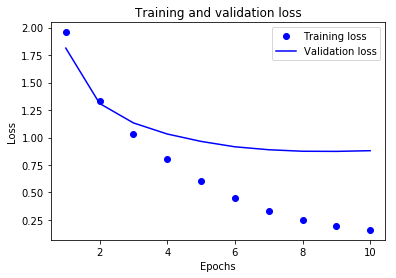

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

epochs = range(1, EPOCHS + 1)

# "bo" specifies "blue dot"
plt.plot(epochs, tr_loss_list, 'bo', label='Training loss')
# b specifies a "solid blue line"
plt.plot(epochs, val_loss_list, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

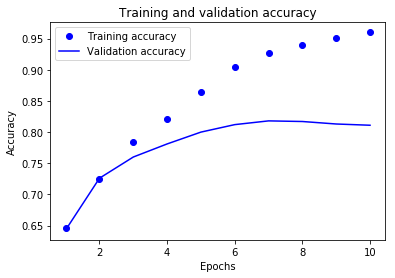

In [19]:
plt.clf()   # Clear plot

plt.plot(epochs, tr_accuracy_list, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy_list, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Step 10) Testing your model
Now that we have successfully trained our model and our training accuracy has jumped over 90%, we need to test it. The test accuracy is a better evaluation metric for how our model will perform in the real world.

In [14]:
loss, accuracy = model.evaluate(test_data, test_labels)
print('Test accuracy: %.2f' % (accuracy))

2246/2246==============================] - 0s 63us/sample - loss: 1.2530 - acc: 0.7765
Test accuracy: 0.78
